# Computational Image Analysis

### *BSc (Hons) Biology and Mathematics Joint Project*

## Import packages

Required Python packages are imported here.

In [4]:
import sys
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Circle-Fit
import circle_fit as cf

# Import Shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Add path to MCSTracker package
sys.path.append('C:/Users/sean2/Documents/Biology/Dissertation/MCSTracker/src/')

# Import MCSTracker packages
import mesh
import tracking

## Defining Functions

Define relevant functions for processing and analysing LECs

### Process Cellpose segmentations (from LEC Analysis code)

In [5]:
def read_in_images_unchanged(path_to_images):
    '''
    A function to read in images from a specified folder and store them in an array.
    
    Parameters
    ---------- 
    path_to_images: string
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/image_folder/'
    
    Output
    ------
    An array containing the image arrays.
    '''
    
    #List the names of the files in the specified folder numerically.
    list_of_file_paths = list_file_paths_in_folder_numerically(path_to_images)
    
    #Make an empty array to store the images.
    images=[]
    
    #Read in the input files and append them to the array. 
    #cv2.IMREAD_UNCHANGED ensures that the properties of the images (e.g. bit depth and number of channels) are not changed.        
    for frame_index in range(len(list_of_file_paths)):
        image = cv2.imread(list_of_file_paths[frame_index], cv2.IMREAD_UNCHANGED)
        image_copy = image.copy()
        images.append(image_copy)
    
    #Return the array of images.   
    return images

def read_in_and_save_grayscale_raw_images(self, saving_path, save=True):
        '''
        Read in the raw TIF images, convert them to grayscale (single channel) images, and save the grayscale images.
        Returns the grayscale versions as a list of ndarrays.
        
        Parameters
        ----------
        saving_path: string
        The absolute path to the folder where the grayscale images will be saved, e.g. 'C:/Users/test/test_folder/'
        
        Output
        ------
        Grayscale versions of the raw TIF images, as a list of ndarrays.
        '''
        print('Reading in images and saving grayscale copies.')
        #Make a list to store the file paths of the raw TIF images.
        unsorted_raw_image_file_paths = []
        #Loop through all of the objects in the folder containing the raw TIF images, PNG masks and _seg.npy segmentations.
        for files in os.listdir(self.path_to_original_segmentation_sequence):
            #If the object name ends with .tif, i.e. it is one of the raw TIF images,
            if files.endswith('.tif'):
                #Join the folder path to the name of the file, to get the absolute file path.
                file_path=os.path.join(self.path_to_original_segmentation_sequence, files)
                #Append the file path to the list of file paths.
                unsorted_raw_image_file_paths.append(file_path)
        #Sort the list of file paths numerically.
        sorted_raw_image_file_paths = sorted(unsorted_raw_image_file_paths, key=self.numerical_sorting_function) 
        #Create an empty list to store the grayscale versions of the raw images.
        grayscale_raw_images = []
        #Loop through the absolute file paths in the list of numerically sorted absolute file paths.
        for frame_index in range(len(sorted_raw_image_file_paths)):
            #Read in the image. cv2.IMREAD_UNCHANGED ensures that the image is not changed.
            raw_image = cv2.imread(sorted_raw_image_file_paths[frame_index], cv2.IMREAD_UNCHANGED)
            #Convert the raw image to grayscale (single channel).
            grayscale_raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
            #Make a copy of the grayscale image.
            grayscale_raw_image_copy = grayscale_raw_image.copy()
            #Append the copy of the grayscale image to the list of grayscale raw images.
            grayscale_raw_images.append(grayscale_raw_image_copy)
            #If saving is desired,
            if save==True:
                #Define the name of the image file and append it to the path to the folder where the image will be saved.
                file_name = saving_path + self.data_identifier_string + '_gray_' + str(frame_index) + '.tif'
                #Convert the grayscale image to a PIL Image format from an array.
                image_to_save = Image.fromarray(grayscale_raw_image_copy)
                #Save the image.
                image_to_save.save(file_name)
        #Return the list of grayscale raw images. Each image is an ndarray.   
        return grayscale_raw_images

def list_file_paths_in_folder_numerically(path_to_folder):
    '''
    Numerically list file paths in the specified folder.
    
    Parameters
    ---------- 
    path_to_folder: string 
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/folder/'
    
    Output
    ------
    A 1D numpy array of numerically sorted file paths.
    '''
    
    #Make an empty array to store the file names.
    file_paths= []
        
    #Append the path to each file in the specified folder to the list of file names.
    #Loop through the names of all of the items in the folder.
    for files in os.listdir(path_to_folder):
        #If a given item is a file,
        if os.path.isfile(os.path.join(path_to_folder, files)):
            #Get its path,
            file_path = os.path.join(path_to_folder, files)
            #and append the path to the list.
            file_paths.append(file_path)
                
    #Sort the file paths numerically.
    sorted_file_paths = sort_filenames_numerically(file_paths)
    
    #Return the sorted file paths.
    return sorted_file_paths

def sort_filenames_numerically(list_of_file_names):
    '''
    Sort a list of file names numerically.
    '''      
    numerically_sorted_filenames=sorted(list_of_file_names, key=numerical_sorting_function)       
    return numerically_sorted_filenames
      

def numerical_sorting_function(filename):
    '''
    A helper function which sorts file names numerically. 
        
    '''
    nondigits = re.compile("\D")
    return int(nondigits.sub("", filename))


### Finding cell edges

* Obtain cell outline points (contours) and triple cell junctions (nodes) using functions programmed in MCSTracker code (Kursawe, 2016)
* Adjust nodes to closest contour point
* Obtain edges from adjusted nodes and contours

In [6]:
def get_contours(frame_image, image_height):
    '''
    Get a list of contours around each cell in the image adjusted to correct axis scaling.
    
    Parameters
    ----------
    frame_image : ndarray
        an image as integer numpy array
    
    image_height : integer
        height of image in pixels for y-axis transformation

    Output
    ------
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a contour array for that segmented cell
    '''
    contours = {} # Initialise dictionary to store contours of each cell
    
    # Obtain contour list and cell ids using mesh function
    contour_list, cell_ids = mesh.get_contour_list(frame_image)
    
    # Loop through each cell to adjust contour points to the correct axis scaling
    for i, cell_id in enumerate(cell_ids):
        x = contour_list[i][0][:, 0, 0] # Extract x-coords
        y = image_height - contour_list[i][0][:, 0, 1] # Extract y-coords and invert y-axis
        
        # Append inital point to the end of the x and y arrays
        x = np.append(x, [x[0]], axis=0) 
        y = np.append(y, [y[0]], axis=0)
        
        # Add adjusted array of contour points to cell id key value
        contours[cell_id] = np.column_stack((x, y))
        
    return contours

def get_mesh_sequence(path_to_images):
    '''
    Reads a folder of .tif files and transforms it into a sequence of mesh objects.
    
    Parameters
    ----------
    path_to_images : string
        path to folder that contains the segmented .tif files  

    Output
    ------
    mesh_sequence : list of Mesh instances
        elements of the list are instances of Mesh
    '''
    mesh_sequence = mesh.read_sequence_from_data(path_to_images)
    return mesh_sequence

def get_distance(a, b):
    '''
    Calculates the Euclidean distance between two points.
    '''
    return np.sqrt(np.sum((a - b)**2))

def get_closest_point(array, target_point):
    """
    Find the closest point to the target point in an array of points.
    """
    min_distance = np.inf  # Initialise minimum distance to infinity
    closest_point = None   # Initialise closest point to None
    
    # Loop through each point in the array
    for point in array:
        distance = get_distance(point, target_point)
        
        # Update closest_point if a closer point is found
        if distance < min_distance:
            min_distance = distance
            closest_point = point
    
    return closest_point

def is_array_in_list(array, array_list):
    """
    Function to check if a given array is identical to any array in a list.
    """
    for arr in array_list:
        if np.array_equal(array, arr):
            return True
    return False

def adjust_nodes(nodes, contours):
    '''
    Adjusts the position of nodes to nearest contour point
    
    Parameters
    ----------
    nodes : list
        list of unadjusted nodes for a segmented cell
    
    contours : nparray
        2D array of contour points for a segmented cell
        
    Output
    ------
    adjusted_nodes : list
        list of nodes adjusted to the correct position
    '''
    adjusted_nodes = [] # Initialise list to store adjusted nodes
    
    # Loop through nodes
    for node in nodes:
        # Find the closest point in the contour array to the node
        closest_point = get_closest_point(contours, node)
        # Add the adjusted node to the new list if not identical to previous node
        if not is_array_in_list(closest_point, adjusted_nodes):
            adjusted_nodes.append(closest_point)
        
    return adjusted_nodes

def get_nodes(frame_mesh, contours):
    '''
    Finds triple junctions (nodes) from mesh sequence and adjusts them to the nearest contour point.
    
    Parameters
    ----------
    frame_mesh : Mesh instance
        instance of a Mesh object which represents a specific frame
    
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a 2D contour array for that segmented cell

    Output
    ------
    nodes : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a list of adjusted nodes for that segmented cell
    '''
    nodes = {} # Initialise dictionary to store nodes of each cell
    cell_ids = frame_mesh.frame_id_dictionary # Extract ids of cells in Mesh object as dictionary
    
    # Loop through each cell id to extract nodes
    for cell_id in cell_ids.keys():
        # Get element object for current cell id
        current_element = frame_mesh.get_element_with_frame_id(cell_id)
        # Extract positions for each node in the cell
        current_nodes = [node.position for node in current_element.nodes]
        # Adjust nodes to position of nearest contour point
        current_adjusted_nodes = adjust_nodes(current_nodes, contours[cell_id])
        # Add node positions to cell id key value
        nodes[cell_id] = current_adjusted_nodes
    
    return nodes

def get_edges(nodes, contours):
    '''
    Find the edges of cells as the contour points between two nodes
    
    Parameters
    ----------
    nodes : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a list of adjusted nodes for that segmented cell
    
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a 2D contour array for that segmented cell

    Output
    ------
    edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of edges for that segmented cell
    '''    
    edges = {} # Initialise dictionary to store edges of each cell
    
    # Filter out cells with less than 3 nodes
    filtered_nodes = {key: value for key, value in nodes.items() if len(value) >= 3}
    
    # Loop through cells to obtain current nodes and contours
    for cell_id in filtered_nodes:
        current_nodes = filtered_nodes[cell_id]
        current_contours = contours[cell_id]
        n = len(current_nodes)
        
        current_edges = [] # Initialise list of edges for current cell
        # Loop for number of nodes
        for i in range(n):
            node1 = current_nodes[i] # Set first node
            # If the first node is the last in the list, set the second as the first in the list
            if (i+1) == n:
                node2 = current_nodes[0]
            # Otherwise, set the second node as the next in the list
            else:
                node2 = current_nodes[i+1]       
              
            # Find indices of the contour points equal to the nodes
            index1 = np.where((current_contours == node1).all(axis=1))[0]
            index2 = np.where((current_contours == node2).all(axis=1))[0]
            
            # If two indices are found for the index1, choose that with shortest distance to index2
            if (len(index1) > 1):
                if (np.abs(index1[0]-index2) < np.abs(index1[1]-index2)):
                    index1 = index1[0]
                else:
                    index1 = index1[1]
            else:
                index1 = index1[0] # Convert from array to scalar object
            
            # If two indices are found for the index2, choose that with shortest distance to index1
            if (len(index2) > 1):
                if (np.abs(index2[0]-index1) < np.abs(index2[1]-index1)):
                    index2 = index2[0]
                else:
                    index2 = index2[1]
            else:
                index2 = index2[0] # Convert from array to scalar object
            
            # Check if edge crosses index boundary of contour points 
            if index1 > index2:
                # Extract current edge between the two index points
                current_edge = np.concatenate((current_contours[int(index1):-1], current_contours[0:int(index2)]), axis=0)
                current_edges.append(current_edge)
            else:
                current_edge = current_contours[int(index1):int(index2)]
                current_edges.append(current_edge)
            
        edges[cell_id] = current_edges
    return edges


### Detecting lamellipodia

* Define a geometric circle fitting method from circle-Fit package:
    * Obtain circle centre, radius and RMS error
    * Normalise RMS error by arc length to get quality of fit
* Define an edge merge function
    * Merge edges based on convexity and quality of fit
* Define lamellipodia detection function
    * Based on convexity, proportional length, curvature, quality of fit

In [126]:
def get_closest_point_on_circle(point, centre, r):
    '''
    Find the point closest to the current point on a given circle.
    
    Parameters
    ----------
    point : list
        list containing x and y coordinate of a given point
    
    centre : list
        list containing x and y coordinate of the centre of a circle
        
    r : float
        radius of a circle
    
    Output
    ------
    closest_point : list
        list containing x and y coordinate of closest point on the given circle.
    '''
    # Calculate the distance from the circle centre to the point
    distance = get_distance(point, centre)
    # If the point is on the circle, return the point itself
    if distance == r:
        return point
    # Calculate direction vector from centre to the point
    direction = (point - centre) / distance
    # Find closest point on the circle by scaling direction vector
    closest_point = centre + r * direction
    return closest_point

def get_arc_length(edge, centre, r):
    '''
    Calculate the arc length of a fitted edge.
    
    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge
    
    centre : list
        list containing x and y coordinate of the centre of a circle
        
    r : float
        radius of a circle
    
    Output
    ------
    arc_length : float
        value of arc length of edge segment    
    '''
    # Find arc endpoints (p1 and p3) and middle point (p2)
    # (Need to calculate two arc lengths to control for longer arcs)
    p1 = get_closest_point_on_circle(edge[0], centre, r)
    p2 = get_closest_point_on_circle(edge[(len(edge)-1) // 2], centre, r)
    p3 = get_closest_point_on_circle(edge[-1], centre, r)
    
    # Get length of chord 
    chord1 = get_distance(p1, p2)
    chord2 = get_distance(p2, p3)
    
    # Calculate the central angles
    # (One half of chord is the side of a right angled triangle)
    theta1 = 2 * np.arcsin(chord1 / (2 * r))
    theta2 = 2 * np.arcsin(chord2 / (2 * r))
    
    # Calculate arc length
    arc_length = (theta1 + theta2) * r
    return arc_length    

def get_initial_guesses(edge):
    '''
    Compute initial guess for center coordinates (xc, yc) and radius (r) of a circle
    based on given edge.

    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge

    Output
    ------
    inits : nparray
        1D containing initial guesses (floats) for centre coords and radius of the circle
    '''
    # Compute centroid of edge points
    centroid = np.mean(edge, axis=0)

    # Use centroid as initial guess for center coordinates (xc, yc)
    xc, yc = centroid

    # Compute distances from the centroid to each point
    distances = np.linalg.norm(edge - centroid, axis=1)

    # Use the maximum distance as the initial guess for the radius
    r = np.max(distances)
    
    inits = np.array([xc, yc, r])
    return inits

def get_circle_fit(edge):
    '''
    Geometric circle fit (minimizing orthogonal distances) based on the standard Levenberg-Marquardt scheme in the full
    (a,b,R) parameter space. Returns RMS error normalised by arc length.
    
    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge
        
    inits : nparray
        array of [xc, yc, r] initial guess
        
    Output
    ------
    xc : float
        x coordinate of the circle fit
        
    yc : float
        y coordinate of the circle fit
        
    r : float
        radius of the circle fit
        
    norm_sigma : float
        sigma (RMS of error) of the circle fit normalised with arc length
    '''
    #Ignore runtime warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Check that edges are of sufficient length
    if len(edge) < 3:
        raise ValueError("Edge must contain three or more points")        
    
    # Get initial guesses for circle fit
    inits = get_initial_guesses(edge)
    #xci, yci, ri, sigmai = cf.taubinSVD(edge)
    #inits = np.array([xci, yci, ri])
    
    # Get geometric circle fit using initial values
    for i in range(10):
        try:
            xc, yc, r, sigma = cf.lm(edge, inits)
            break
        except Exception:
            inits += 80
    
    # Normalise the sigma value by arc length
    arc_length = get_arc_length(edge, [xc, yc], r)
    norm_sigma = sigma / arc_length
    
    return xc, yc, r, norm_sigma

def get_midpoint(point1, point2):
    '''
    Calculate the midpoint between two 2D points.
    '''
    x1, y1 = point1
    x2, y2 = point2
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    return (mid_x, mid_y)

def get_cell_polygon(edges):
    '''
    Get Shapely polygon of current cell.
    '''
    cell_points = [] # Initialise list to store cell points
    # Loop through cell edges to add first and middle points
    for edge in edges:
        cell_points.append(edge[0])
        cell_points.append(edge[len(edge)//2])
    return Polygon(cell_points)

def get_cell_polygon(edges):
    '''
    Get Shapely polygon of current cell from edges
    '''
    cell_points = np.concatenate(edges)
    return Polygon(cell_points)

def is_merge(edge1, edge2, cell_edges, sigma):
    '''
    Decide whether to merge two edges. Check convexity and quality of a combined circle fit.
    
    Parameters
    ----------
    edge1, edge2 : nparrays
        2D arrays of given cell edges
        
    cell_edges : nparray
        list of 2D arrays of edges of a given cell
    
    sigma : float
        threshold quality of fit value for merging. Default is 0.016
        
    Output
    ------
    Boolean. True if edges should be merged.
    '''
    # Need three or more points to fit a circle
    if len(edge1) < 3 or len(edge2) < 3:
        return False
    
    # Check for convexity
    # Get Shapely polygon of current cell
    cell_poly = get_cell_polygon(cell_edges)
    # Calculate midpoint between ends of given edges
    midpoint1 = get_midpoint(edge1[0], edge1[-1])
    midpoint2 = get_midpoint(edge2[0], edge2[-1])
    # Get Shapely point element of each midpoint
    point1 = Point(midpoint1)
    point2 = Point(midpoint2)
    # Do not merge if midpoints are not contained in cells (i.e., edges are concave)
    if not (cell_poly.contains(point1) and cell_poly.contains(point2)):
        return False
    
    # Get circle fits for each edge
    xc1, yc1, r1, sigma1 = get_circle_fit(edge1)
    xc2, yc2, r2, sigma2 = get_circle_fit(edge2)
    
    # Get circle fit for combined edge
    combined_edge = np.concatenate((edge1, edge2))
    xcc, ycc, rc, sigmac = get_circle_fit(combined_edge)
    
    # Do not merge if quality of fit for combined fit is over threshold value 
    if sigmac > sigma:
        return False
    
    return True

def get_merged_edges(edges, sigma = 0.05):
    '''
    Find new list of merged edges of cells in a frame. Edges are merged based on convexity and quality of a combined circle fit.
    
    Parameters
    ----------
    edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of edges for that segmented cell
    
    sigma : float
        threshold quality of fit value for merging. Default is 0.016
    
    Output
    ------
    merged_edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of merged edges for that segmented cell
    '''
    merged_edges = {} # Initialise dictionary to store merged edges for each edge
    
    # Loop through each cell
    for cell_id in edges:
        current_edges = edges[cell_id] # Extract the edges of the current cell
        n = len(current_edges)
        current_merge = [] # Initialise list to store current merged edges
        current_sigma = sigma # Create a copy of the sigma value to change with each iteration
        
        # Loop for each edge in the cell
        for i in range(n):
            # If the first iteration...
            if not current_merge:
                # Set the first edges to check for merge
                edge1 = current_edges[i-1]
                edge2 = current_edges[i]
                # Add merged edge if they meet criteria 
                if is_merge(edge1, edge2, current_edges, current_sigma):
                    current_merge.append(np.concatenate((edge1, edge2)))
                    initial_merge = True # Keep track if initial edges were merged
                    current_sigma = sigma*2 # Increase quality of fit threshold for next iteration if the two edges are merged
                else:
                    current_merge.append(edge2) # Add second edge if they do not meet criteria
                    initial_merge = False
                    current_sigma = sigma # Keep threshold the same if the two edges are not merged
            
            # If the last iteriation and if edges were merged on the first iteration...
            elif i == n-1 and initial_merge:
                # Set the edges from the merged list
                edge1 = current_merge[-1]
                edge2 = current_merge[0]
                current_sigma = sigma*2 # Increase threshold for this instance
                # Add merged edge if they meet criteria and remove unmerged final edge in merged list
                if is_merge(edge1, edge2, current_edges, current_sigma):
                    current_merge[0] = np.concatenate((edge1, edge2))
                    current_merge[:-1]
                    
            else:
                # Set first edge as the last in the merged list
                edge1 = current_merge[-1]
                # Set the second edge from the current edge list
                edge2 = current_edges[i]
                # Add the merged edge if they meet criteria
                if is_merge(edge1, edge2, current_edges, current_sigma):
                    current_merge[-1] = np.concatenate((edge1, edge2))
                    current_sigma = sigma*2
                # Add the unmerged current edge if not
                else:
                    current_merge.append(edge2)
                    current_sigma = sigma

        # Add list of merged edges at current cell id
        merged_edges[cell_id] = current_merge
    return merged_edges

def is_lamellipodium(edge, cell_edges, curvature_lower = 0.008, curvature_upper = 0.04, sigma = 0.1, proportion = 0.2, getstats = False):
    '''
    Decide whether an edge is a lamellipodium and receive the selection data (optional).
    
    Parameters
    ----------
    edge : nparray
        2D array of given cell edge
        
    cell_edges : nparray
        list of 2D arrays of edges of a given cell
    
    curvature : float
        threshold curvature value for lamellipodia. Default is 0.005
        
    sigma : float
        threshold quality of fit value for lamellipodia. Default is 0.02
    
    proportion : float
        threshold value for length of edge proportional to total cell edge for lamellipodia. Default is 0.2
    
    getstats : Boolean
        decides whether selection data is output. Default is no data output
        
    Output
    ------
    is_lamel : Boolean
        True if given edge is detected as a lamellipodium
    
    curvature : float (optional)
        curvature value for given edge
        
    sigma : float (optional)
        quality of fit value for given edge
    
    proportion : float (optional)
        value for length of edge proportional to total cell edge for given edge        
    '''
    
    # Get total cell outline for finding proportional length
    cell_outline = np.concatenate(cell_edges)
    # Get Shapely polygon of current cell
    cell_poly = get_cell_polygon(cell_edges)
    
    # Set lamellipodia identifier as False
    is_lamel = False
    # Get geometric circle fit for current edge
    xc, yc, r, sigmai = get_circle_fit(edge)
    # Calculate curvature and proportional length
    curvaturei = 1 / r
    proportioni = len(edge)/len(cell_outline)
    
    # Check if edge fulfils given threshold criteria
    if curvaturei > curvature_lower and curvaturei < curvature_upper and sigmai < sigma and proportioni > proportion and len(edge) > 20:
        # Check for convexity
        midpoint = get_midpoint(edge[0], edge[-1])
        point = Point(midpoint)
        if cell_poly.contains(point):
            is_lamel = True
    
    # Return selection data if asked
    if getstats:
        return [is_lamel, curvaturei, sigmai, proportioni]
    else:
        return is_lamel


### Lamellipodia Analysis

* Define a function for determining direction of movement (lamellipodia angle of direction)

In [8]:
def get_direction(lamellipodium):
    '''
    Calculate the direction of a given lamellipodium in radians using np.arctan2 function
    
    Parameters
    ----------
    lamellipodium : nparray
        2D array of a given lamellipodium
    
    Output
    ------
    direction : float
        direction of the lamellipodium in radians adjusted for each quadrant
    '''
    # Fit a circle to the lamellipodium
    xc, yc, r, sigma = get_circle_fit(lamellipodium)
    
    # Find the median point in the lamellipodium array
    median = lamellipodium[(len(lamellipodium) - 1) // 2]
    # Calculate the difference between the x- and y-coords of the centre of the fitted circle and the median point
    dx = median[0] - xc
    dy = median[1] - yc
    
    # Calculate direction of the vector using arctan2 numpy function
    direction = np.arctan2(dy, dx)
    return direction


## Code usage

Using model segmentations from Lydia McQuoid

### Processing Cellpose segmentations

First define function to convert images grayscale in order to extract mesh sequence

In [9]:
# Define the path to the tracked segmentations   
path_to_segmentations = 'C:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale/'
# Read in the tracked segmentations
segmentations = read_in_images_unchanged(path_to_segmentations)
# Create mesh sequence of cells in each frame
mesh_sequence = get_mesh_sequence(path_to_segmentations)

readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_00.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_01.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_02.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_03.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_04.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_05.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_06.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_07.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-cad-GFP_im_0_08.tiff
readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images_grayscale\1_DE-c

150


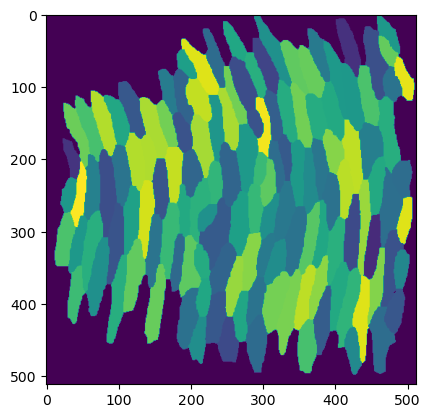

In [10]:
print(len(segmentations))
first_frame = segmentations[0]
plt.figure()
plt.imshow(first_frame)
plt.show()

### Visual Analysis

Find frames for comparing manual and computational lamellipodia detection.

- LEC frame timepoints:
    - **Frame 0:** Cell shape begins to change
    - **Frame 43:** Before posterior migration
    - **Frame 62:** Early posterior migration
    - **Frame 85:** Late posterior migration
    - **Frame 107:** Posterior migration ends; Dorsal migration and apical constriction

#### Frame 0

In [128]:
current_mesh = mesh_sequence[0]
current_frame = segmentations[0] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]

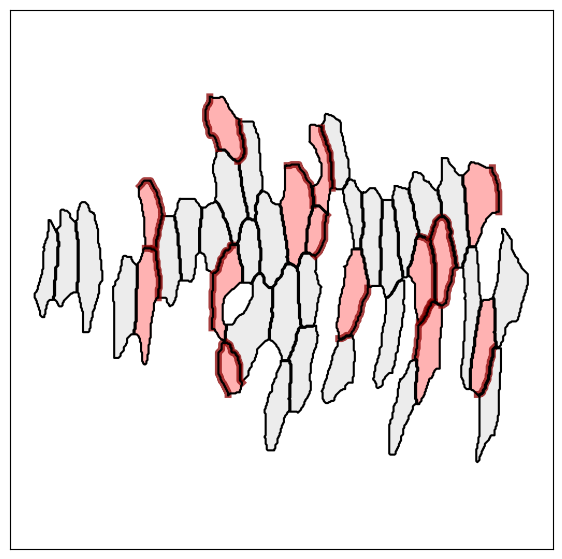

In [129]:
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('frame0_comp.png', dpi=300)
plt.show()

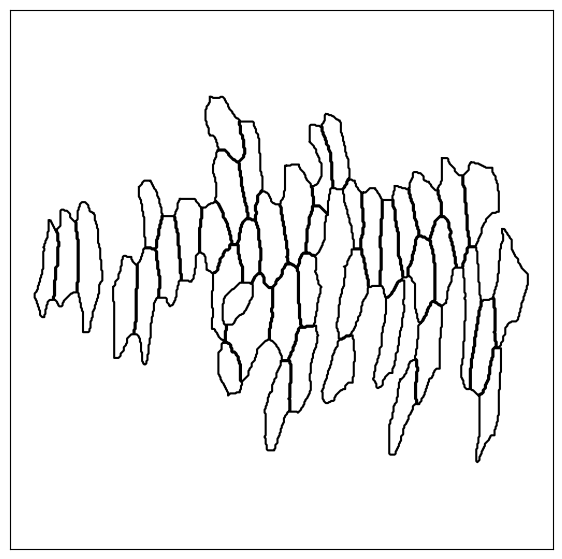

In [169]:
# Plot only cells
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for cell_id in cell_x:
    color = cmap(cell_id)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black', linewidth=1.5)
plt.savefig('frame0_edges.png', dpi=300)
plt.show()

#### Frame 43

In [130]:
current_mesh = mesh_sequence[43]
current_frame = segmentations[43] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]

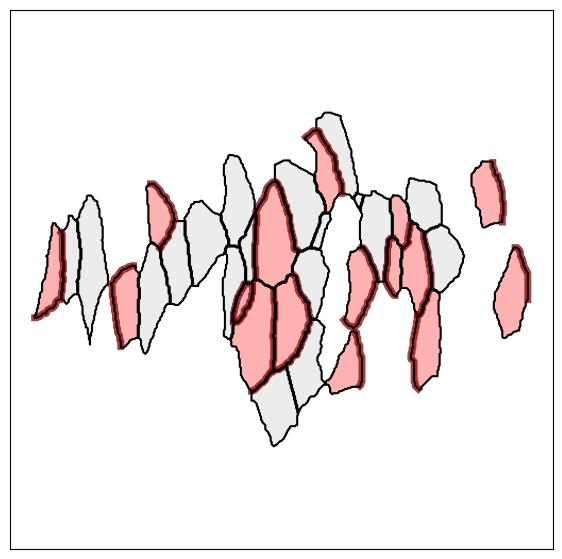

In [131]:
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('frame43_comp.png', dpi=300)
plt.show()

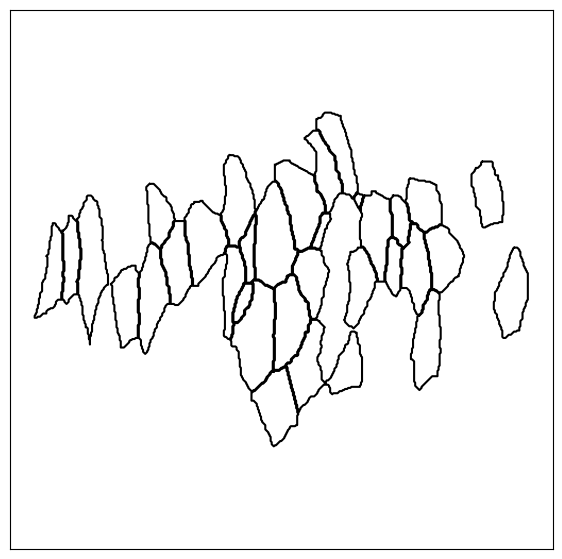

In [179]:
# Plot only cells
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for cell_id in cell_x:
    color = cmap(cell_id)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black', linewidth=1.5)
plt.savefig('frame43_edges.png', dpi=300)
plt.show()

#### Frame 74

In [132]:
current_mesh = mesh_sequence[74]
current_frame = segmentations[74] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]

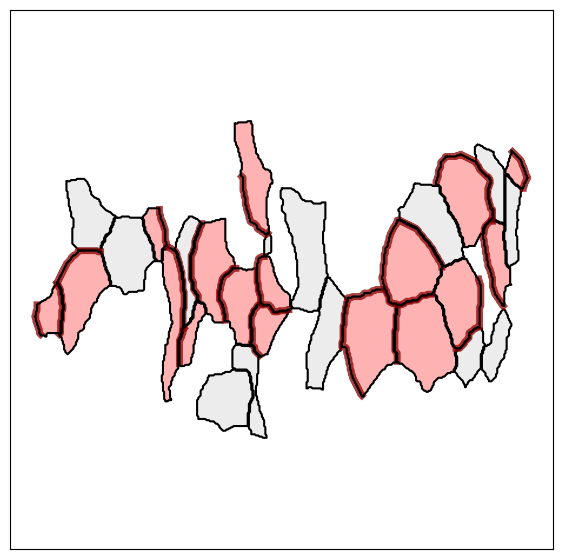

In [133]:
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('frame74_comp.png', dpi=300)
plt.show()

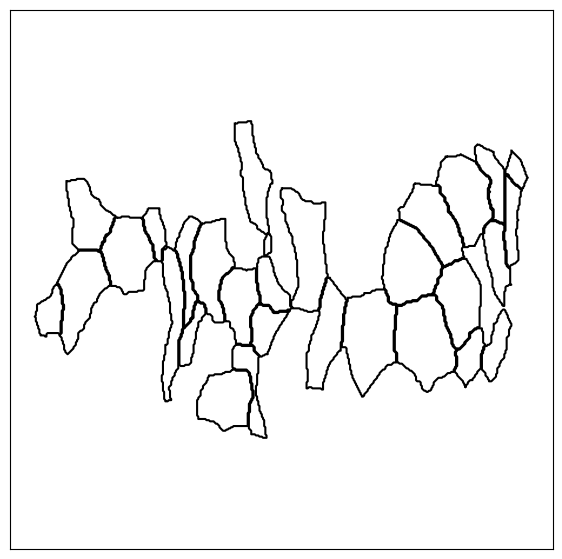

In [182]:
# Plot only cells
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for cell_id in cell_x:
    color = cmap(cell_id)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black', linewidth=1.5)
plt.savefig('frame74_edges.png', dpi=300)
plt.show()

#### Frame 91

In [134]:
current_mesh = mesh_sequence[91]
current_frame = segmentations[91] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]

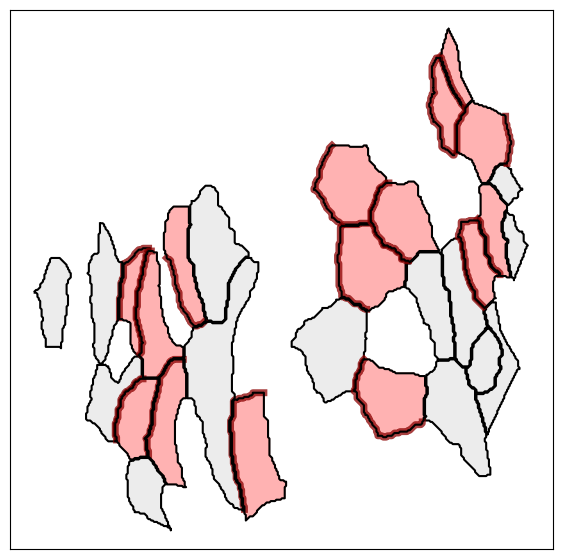

In [135]:
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('frame91_comp.png', dpi=300)
plt.show()

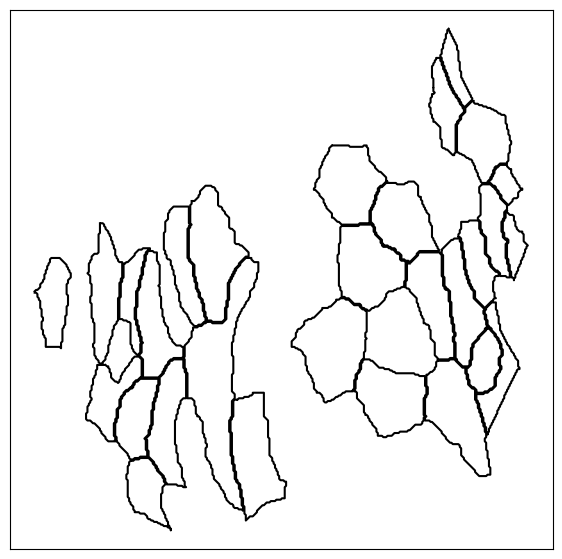

In [185]:
# Plot only cells
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for cell_id in cell_x:
    color = cmap(cell_id)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black', linewidth=1.5)
plt.savefig('frame91_edges.png', dpi=300)
plt.show()

#### Frame 102

In [136]:
current_mesh = mesh_sequence[102]
current_frame = segmentations[102] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]  

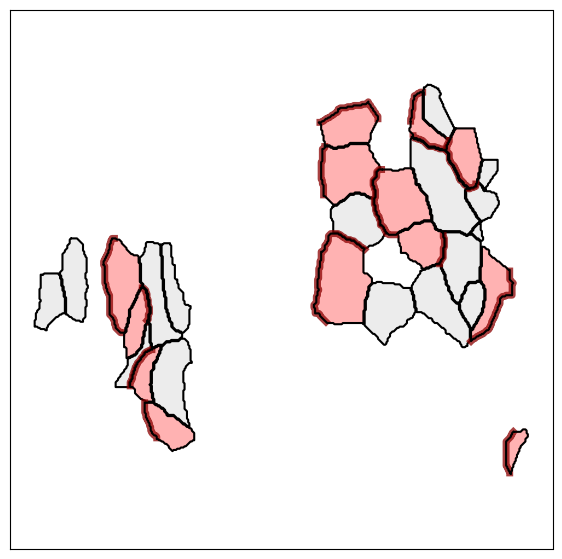

In [137]:
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('frame102_comp.png', dpi=300)
plt.show()

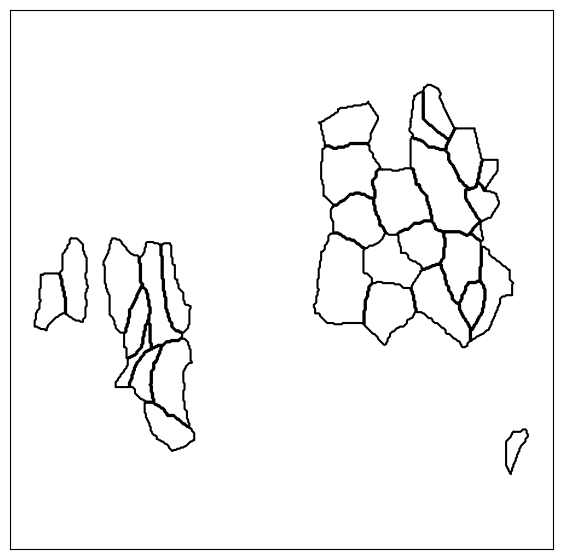

In [188]:
# Plot only cells
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for cell_id in cell_x:
    color = cmap(cell_id)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black', linewidth=1.5)
plt.savefig('frame102_edges.png', dpi=300)
plt.show()

#### Extra Frame 72

Compare with frame 73 to show the discrepancies between frames

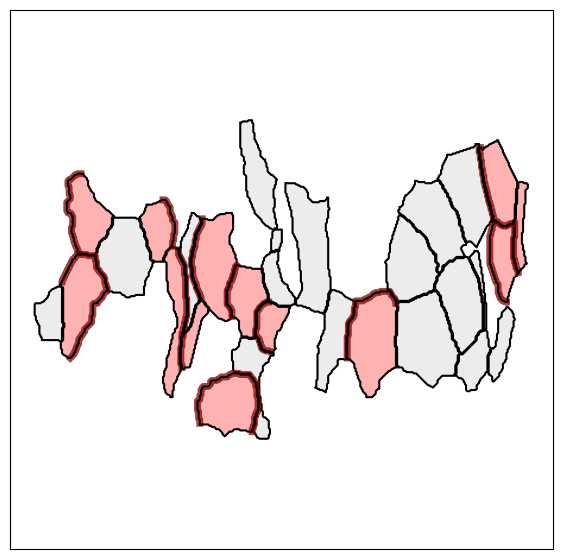

In [166]:
current_mesh = mesh_sequence[72]
current_frame = segmentations[72] 
    
contours = get_contours(current_frame, 512)
nodes = get_nodes(current_mesh, contours)
edges = get_edges(nodes, contours)

merged_edges = get_merged_edges(edges, sigma=0.05)

# Collect lamellipodia edge points in a dictionary
lamellipodia = {}
for cell_id in merged_edges:
    lamellipodia[cell_id] = [] # Initialise dictionary key for the cell
    for edge in merged_edges[cell_id]:
        if len(edge) >= 3: # Do not include edges with less than three points
            if is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2):
                lamellipodia[cell_id].append(edge) # Add lamellipodia to dictionary

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia:
    lameli = lamellipodia[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi

# Extract x and y coords of cell outline
for cell_id in edges:
    cell_edge = np.concatenate(edges[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edge]
    cell_y[cell_id] = [point[1] for point in cell_edge]
    
fig = plt.figure(figsize=(7,7))
# Make axis scales equal
plt.axis('equal')
# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Loop through cells
for j, cell_id in enumerate(cell_x):
    if lamel_x[cell_id]:
        # Fill cell in red if it has lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.3, color='red')  # Fill the polygon
        for i in range(len(lamel_x[cell_id])):
            # Plot lamellipodia
            plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='darkred', alpha=0.75, linewidth=5)
    else:
        # Fill cell in grey if it does not have lamellipodia
        plt.fill(cell_x[cell_id], cell_y[cell_id], alpha=0.15, color='grey')  # Fill the polygon
    # Plot cell outline
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.savefig('extraframe72_comp.png', dpi=300)
plt.show()

### Quantitative Analysis

Obtain data from computational detection for analysis

In [139]:
# Initialise dataframe for storing detection data
headers = ['Lamellipodia', 'Curvature', 'Quality of Fit', 'Proportional Length', 'Direction of Movement', 'Frame']
df2 = pd.DataFrame(columns = headers)

nframes = len(mesh_sequence)
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = segmentations[n] 
    
    contours = get_contours(current_frame, 512)
    nodes = get_nodes(current_mesh, contours)
    edges = get_edges(nodes, contours)
    
    merged_edges = get_merged_edges(edges, sigma=0.05)
    
    for cell_id in merged_edges:
        for edge in merged_edges[cell_id]:
            if len(edge) >= 3:
                data = is_lamellipodium(edge, merged_edges[cell_id], curvature_lower=0.008, sigma=0.1, proportion=0.2, getstats=True)
                if data[0]:
                    data.append(get_direction(edge))
                else:
                    data.append(None)
                data.append(n)
                df2.loc[len(df2)] = data

In [140]:
print('Number edges:', len(df2))
print('Number of lamellipodia:', df2['Lamellipodia'].sum())
df2.head()

Number edges: 20119
Number of lamellipodia: 1722


,Lamellipodia,Curvature,Quality of Fit,Proportional Length,Direction of Movement,Frame
0,False,0.001841,0.004515,0.430052,NaN,0
1,False,0.088733,0.022499,0.036269,NaN,0
2,True,0.010105,0.016044,0.248705,-0.267076,0
3,False,0.000156,0.008089,0.238342,NaN,0
4,False,0.058563,0.024928,0.046632,NaN,0


In [155]:
# Subset into dataframe containing only edges defined as lamellipodia
lam_true = df2[df2['Lamellipodia'] == True]
# Save dataframe as csv
lam_true.to_csv('lamel.csv', index=False)
print(f'Number of frames containing lamellipodia: {len(lam_true.groupby('Frame'))}')

136

Time groups:
1. Frame 0-25 : Pre cell shape changes
2. Frame 26-55 : Cell shape changes
2. Frame 56-75 : Early posterior migration
3. Frame 76-95 : Late posterior migration
4. Frame 96-149 : Apical constriction and closure

In [144]:
lam_true_t1 = lam_true[lam_true['Frame'].between(0,25)]
lam_true_t2 = lam_true[lam_true['Frame'].between(26,55)]
lam_true_t3 = lam_true[lam_true['Frame'].between(56,75)]
lam_true_t4 = lam_true[lam_true['Frame'].between(76,95)]
lam_true_t5 = lam_true[lam_true['Frame'].between(96,149)]

In [145]:
print(f'There are {len(lam_true_t1)} lamellipodia from frame 0 to 25')
print(f'There are {len(lam_true_t2)} lamellipodia from frame 26 to 55')
print(f'There are {len(lam_true_t3)} lamellipodia from frame 56 to 75')
print(f'There are {len(lam_true_t4)} lamellipodia from frame 76 to 95')
print(f'There are {len(lam_true_t5)} lamellipodia from frame 96 to 149')

There are 440 lamellipodia from frame 0 to 25
There are 452 lamellipodia from frame 26 to 55
There are 293 lamellipodia from frame 56 to 75
There are 291 lamellipodia from frame 76 to 95
There are 246 lamellipodia from frame 96 to 149


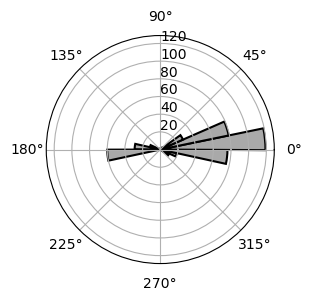

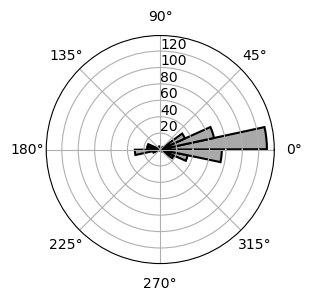

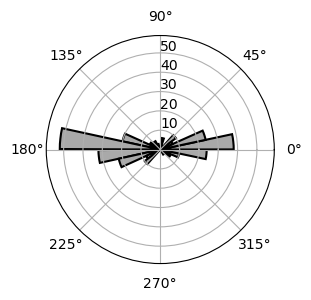

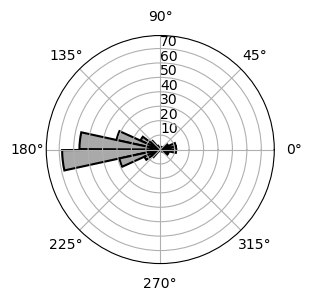

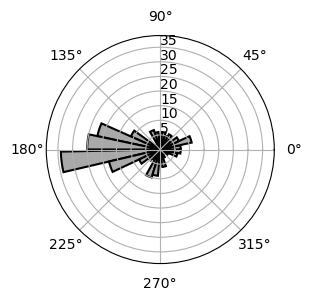

In [151]:
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'}, constrained_layout=True)
ax.set_rlabel_position(90)
ax.set_ylim(0, 129)
ax.hist(lam_true_t1['Direction of Movement'], bins = 30, color='darkgrey', edgecolor='black', linewidth=1.5)
plt.savefig('direc_hist1.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'}, constrained_layout=True)
ax.set_rlabel_position(90)
ax.set_ylim(0, 139)
ax.hist(lam_true_t2['Direction of Movement'], bins = 30, color='darkgrey', edgecolor='black', linewidth=1.5)
plt.savefig('direc_hist2.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'}, constrained_layout=True)
ax.set_rlabel_position(90)
ax.set_ylim(0, 59)
ax.hist(lam_true_t3['Direction of Movement'], bins = 30, color='darkgrey', edgecolor='black', linewidth=1.5)
plt.savefig('direc_hist3.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'}, constrained_layout=True)
ax.set_rlabel_position(90)
ax.set_ylim(0, 79)
ax.hist(lam_true_t4['Direction of Movement'], bins = 30, color='darkgrey', edgecolor='black', linewidth=1.5)
plt.savefig('direc_hist4.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'}, constrained_layout=True)
ax.set_rlabel_position(90)
ax.set_ylim(0, 39)
ax.hist(lam_true_t5['Direction of Movement'], bins = 30, color='darkgrey', edgecolor='black', linewidth=1.5)
plt.savefig('direc_hist5.png', dpi=300)
plt.show()

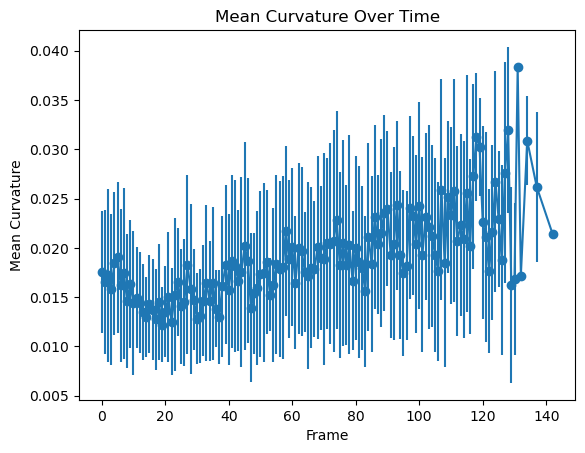

In [152]:
# Group by 'Frame' and calculate mean and standard error of 'Curvature'
curvature_group = lam_true.groupby('Frame')['Curvature'].agg(['mean', 'std'])

# Plot mean Curvature over each frame with error bars
plt.errorbar(curvature_group.index, curvature_group['mean'], yerr=curvature_group['std'], fmt='-o')
plt.xlabel('Frame')
plt.ylabel('Mean Curvature')
plt.title('Mean Curvature Over Time')
plt.show()

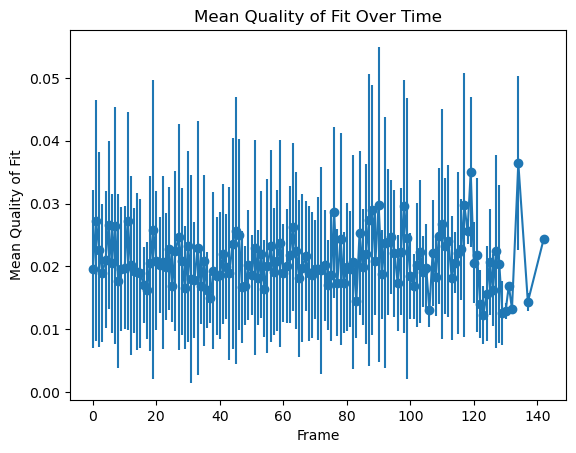

In [153]:
# Group by 'Frame' and calculate mean and standard error of 'Quality of Fit'
quality_group = lam_true.groupby('Frame')['Quality of Fit'].agg(['mean', 'std'])

# Plot mean Curvature over each frame with error bars
plt.errorbar(quality_group.index, quality_group['mean'], yerr=quality_group['std'], fmt='-o')
plt.xlabel('Frame')
plt.ylabel('Mean Quality of Fit')
plt.title('Mean Quality of Fit Over Time')
plt.show()

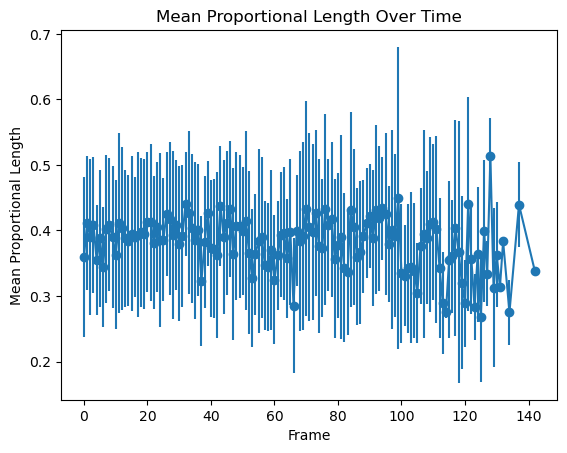

In [154]:
# Group by 'Frame' and calculate mean and standard error of 'Curvature'
proportion_group = lam_true.groupby('Frame')['Proportional Length'].agg(['mean', 'std'])

# Plot mean Curvature over each frame with error bars
plt.errorbar(proportion_group.index, proportion_group['mean'], yerr=proportion_group['std'], fmt='-o')
plt.xlabel('Frame')
plt.ylabel('Mean Proportional Length')
plt.title('Mean Proportional Length Over Time')
plt.show()